# **Test Data Preparation and Final Model**

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# import module m_eda_plots as edap
import m_eda_plots as edap


### **Train Data**

In [2]:
client = pd.read_csv('data/client_train.csv')
invoice = pd.read_csv('data/invoice_train.csv')

In [3]:
# merge client and invoice data
df = pd.merge(client, invoice, on='client_id', how='left')
df.shape

(4476749, 21)

In [4]:
df = pd.read_csv('processed_data/df_0.csv')

In [5]:
# summarize the procedure of data processing
def data_processor(df):
    
    # rename disrict to district
    df.rename(columns={'disrict': 'district'}, inplace=True)
    
    # convert date columns to datetime
    df['creation_date'] = pd.to_datetime(df['creation_date'])
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    
    # map the counter_type to integer
    df['counter_type'] = df['counter_type'].map({'ELEC': 0, 'GAZ': 1})

    
    ### create new features ###
    
    # new feature: before
    # create a new categorical feature: if the invoice is issued before the creation date
    df['before'] = df['creation_date'] > df['invoice_date']
    # transform the boolean feature to integer
    df['before'] = df['before'].astype(int)
    df['before'].value_counts()
    
    # new features: year and month
    df['year'] = df['invoice_date'].dt.year
    df['month'] = df['invoice_date'].dt.month
    
    # sum up the consumption of all levels
    df['consumption'] = df['consommation_level_1'] + df['consommation_level_2'] + df['consommation_level_3'] + df['consommation_level_4']
    # calculate the interval between the old and new index
    df['index_interval'] = df['new_index'] - df['old_index']
    
    # divide the consumption by the number of months
    df['consumption_per_month'] = df['consumption'] / df['months_number']
    # divide the interval by the number of months
    df['index_interval_per_month'] = df['index_interval'] / df['months_number']
    
    # create a new feature: if 'counter_coefficient * index_interval != consumption'
    df['diff'] = df['counter_coefficient'] * df['index_interval'] != df['consumption']
    # transform boolean to integer
    df['diff'] = df['diff'].astype(int)
    
    # create a new column to record the number of unique counter_code in each client_id
    df['uniq_counter'] = df.groupby('client_id')['counter_code'].transform('nunique')
    
    # transform data type of counter_statue column to string
    # combine integer and string values into string values ['0', '1', '2', '3', '4', '5']
    df['counter_statue'] = df['counter_statue'].astype(str)
    # combine all values except 0, 1, 2, 3, 4, 5 into 9
    df.loc[~df['counter_statue'].isin(['0', '1', '2', '3', '4', '5']), 'counter_statue'] = '9'
    
    # combine reading_remarque 203, 207, 413 to 5
    df.loc[df['reading_remarque'].isin([203, 207, 413]), 'reading_remarque'] = 5
    
    # create a new column to record the number of unique counter_code in each client_id
    df['uniq_counter_num'] = df.groupby('client_id')['counter_number'].transform('nunique')
    
    return df

In [6]:
# extract the categories of categorical features
def extract_categories(train_df, cat_fs):
    categories = {}
    for f in cat_fs:
        categories[f] = train_df[f].unique().tolist()
    return categories


In [7]:
# sumarize the procedure of data aggregation
def data_aggregator(df, cat_fs, categories):
    
    # get clients dataframe
    if 'target' in df.columns:
        df_agg = df.groupby('client_id').agg({'district': 'mean', 'region': 'mean', 'client_catg': 'mean', 'target': 'mean'}).reset_index()
    else:
        df_agg = df.groupby('client_id').agg({'district': 'mean', 'region': 'mean', 'client_catg': 'mean'}).reset_index()
    
    df['counter_statue'] = df['counter_statue'].astype(int)    
    
    # add back the uniq_counter and uniq_counter_num
    rest_fs = ['uniq_counter', 'uniq_counter_num']
    df_agg = df_agg.merge(df.groupby('client_id')[rest_fs+cat_fs].mean(), how='left', on='client_id')
    
    # counter_code and counter_number are already dealt with previously, therefore I will not include it here
    # calculate aggregation statistics for categorical features
    for f in cat_fs:
        df[f] = pd.Categorical(df[f], categories=categories[f])
        counts = df.groupby(['client_id', f]).size().unstack(fill_value=0)
        counts.columns = [f'{f}_count_{c}' for c in counts.columns]
        df_agg = df_agg.merge(counts, how='left', on='client_id')
        uniq_count = df.groupby('client_id')[f].nunique().rename(f'{f}_uniq_count')
        df_agg = df_agg.merge(uniq_count, how='left', on='client_id')
    
    # list numeric features 
    num_fs = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 
            'new_index', 'months_number', 'consumption', 'index_interval', 'diff', 'consumption_per_month', 'index_interval_per_month']

    # list aggregation functions
    agg_funcs = ['mean', 'std', 'min', 'max', 'sum', 'median', 'skew']

    # calculate aggregation statistics for numeric features
    df_agg_num = df.groupby('client_id')[num_fs].agg(agg_funcs).reset_index()

    # rename columns
    df_agg_num.columns = ['_'.join(filter(None, col_func)) for col_func in df_agg_num.columns]

    # merge dataframes
    df_agg = df_agg.merge(df_agg_num, how='left', on='client_id')
    
    # new feature: transactions_count
    transactions_count = df.groupby('client_id').size()
    df_agg['transactions_count'] = transactions_count.values
    
    # transform the type of categorical variables
    cat_fs = ['district', 'client_catg', 'region', 'counter_type']
    df[cat_fs] = df[cat_fs].astype('category')
    
        
    return df_agg

In [8]:
cat_fs = ['tarif_type', 'counter_statue', 'reading_remarque', 'counter_coefficient', 'counter_type', 'year', 'month', 'before']
    

In [9]:
# execute the data processing
df = data_processor(df)
df.shape

(4476713, 31)

In [10]:
categories = extract_categories(df, cat_fs)

In [11]:
# execute the aggregation
df = data_aggregator(df, cat_fs, categories)
df.shape

(135492, 205)

In [12]:
# features to drop
drop_fs = ['creation_date', 'invoice_date', 'old_index', 'tarif_type']

# drop list obtained from feature selection
drop_lst = ['diff_min', 'diff_max', 'new_index_max', 'before_count_0', 'year_count_2015', 'new_index_median', 'consommation_level_2_std', 'counter_statue_count_9', 'year_count_2016', 'consommation_level_3_median', 'year_count_2011', 'consommation_level_2_mean', 'counter_type_count_0', 'year_count_2017', 'consumption_per_month_std', 'tarif_type_count_13', 'consommation_level_1_max', 'consumption_max', 'year_count_2014', 'index_interval_per_month_skew', 'index_interval_per_month_max', 'counter_type_count_1', 'counter_coefficient_count_6', 'transactions_count', 'before_uniq_count', 'counter_type_uniq_count', 'consommation_level_4_std', 'tarif_type_count_27', 'month_count_1', 'tarif_type_uniq_count', 'consommation_level_4_mean', 'consommation_level_4_median', 'months_number_min', 'index_interval_mean', 'consumption_sum', 'consumption_per_month_median', 'year_count_2012', 'index_interval_per_month_mean', 'consumption_mean', 'consommation_level_1_min', 'months_number_median', 'tarif_type_count_14', 'index_interval_per_month_sum', 'tarif_type_count_8', 'index_interval_std', 'reading_remarque_count_6', 'months_number_mean', 'year_count_2007', 'year_count_2009', 'year_count_2006', 'consommation_level_3_max', 'consommation_level_1_median', 'counter_statue_count_0', 'months_number_max', 'index_interval_sum', 'year_count_2008', 'counter_coefficient_count_1', 'consommation_level_2_sum', 'reading_remarque_count_5', 'index_interval_min']
# drop_lst = []

# drop features, get the final dataframe
df.drop(columns=drop_fs+drop_lst, inplace=True, errors='ignore')
df.shape

(135492, 144)

In [13]:
df.columns

Index(['client_id', 'district', 'region', 'client_catg', 'target',
       'uniq_counter', 'uniq_counter_num', 'counter_statue',
       'reading_remarque', 'counter_coefficient',
       ...
       'diff_median', 'diff_skew', 'consumption_per_month_mean',
       'consumption_per_month_min', 'consumption_per_month_max',
       'consumption_per_month_sum', 'consumption_per_month_skew',
       'index_interval_per_month_std', 'index_interval_per_month_min',
       'index_interval_per_month_median'],
      dtype='object', length=144)

### **Model_LGBM_5**

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from joblib import load
import m_metrics_plots as metp


SEED = 2004

y = df['target']
X = df.drop(['client_id', 'target'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
#cat_fs = ['tarif_type', 'counter_statue', 'reading_remarque', 'counter_coefficient', 'counter_type', 'year', 'month', 'before']


In [21]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
import numpy as np

SEED = 2004

# set the range of hyperparameters
param_bounds = {
    'n_estimators': (50, 1300),
    'max_depth': (1, 30),
    'learning_rate': (0.0001, 0.1),
    'num_leaves': (10, 100),
    'min_child_samples': (5, 50),
    'feature_fraction': (0.1, 1.0),
    'bagging_fraction': (0.1, 1.0)
}

# define the objective function
def lgbm_cv_score(n_estimators, max_depth, learning_rate, num_leaves, min_child_samples, feature_fraction, bagging_fraction):
    model = LGBMClassifier(
        n_estimators=int(round(n_estimators)),
        max_depth=int(round(max_depth)),
        learning_rate=learning_rate,
        num_leaves=int(round(num_leaves)),
        min_child_samples=int(round(min_child_samples)),
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        random_state=SEED,
        class_weight='balanced'
    )
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    return np.mean(scores)

# define the optimizer
optimizer = BayesianOptimization(
    f=lgbm_cv_score,
    pbounds=param_bounds,
    random_state=SEED,
    verbose=2
)

# excute optimization
optimizer.maximize(init_points=10, n_iter=60)
# obtain the best parameters
best_params = optimizer.max['params']
# record the best parameters
print(best_params)
# {'bagging_fraction': 0.7768664929941554, 'feature_fraction': 0.5800113244238196, 'learning_rate': 0.045405241292485854, 'max_depth': 26.812998654781893, 'min_child_samples': 40.65610842403089, 'n_estimators': 179.99929765074197, 'num_leaves': 46.77834351834141}
# {'bagging_fraction': 0.9904678085167807, 'feature_fraction': 0.4002561493202863, 'learning_rate': 0.018120209131260577, 'max_depth': 17.844330034696423, 'min_child_samples': 29.221518003061263, 'n_estimators': 656.0529112822703, 'num_leaves': 22.72954525893533}

|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.8239950850595918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8239950850595918
[LightGBM] [Warning] bagging_fraction is set=0.6289734601988971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6289734601988971
[LightGBM] [Warning] feature_fraction is set=0.8239950850595918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8239950850595918
[LightGBM] [Warning] bagging_fraction is set=0.6289734601988971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6289734601988971
[LightGBM] [Warning] feature_fraction is set=0.8239950850595918, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8239950850595918
[LightGBM] [Warning] bag

[LightGBM] [Warning] feature_fraction is set=0.37414076915242245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37414076915242245
[LightGBM] [Warning] bagging_fraction is set=0.2492521343110019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2492521343110019
------- Model: LGBM_5 -------
Accuracy:  0.8793682423705672
Precision:  0.2830379746835443
Recall:  0.7189710610932476
F1 Score:  0.4061762034514078
F-Beta: 0.5496558505408062
ROC AUC:  0.8902894998403864
Confusion Matrix: 
 [[22712  2832]
 [  437  1118]]
Confusion Matrix (Normalized): 
 [[0.88913248 0.11086752]
 [0.28102894 0.71897106]]
Classification Report: 
               precision    recall  f1-score   support

         0.0      0.981     0.889     0.933     25544
         1.0      0.283     0.719     0.406      1555

    accuracy                          0.879     27099
   macro avg      0.632     0.804     0.670     27099
weighted avg      0.941     0.879     0.903     27099



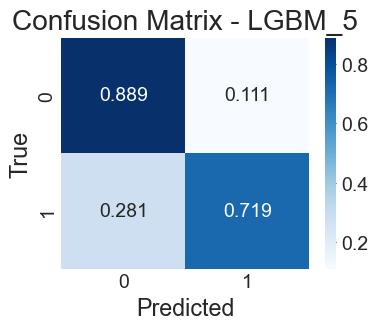

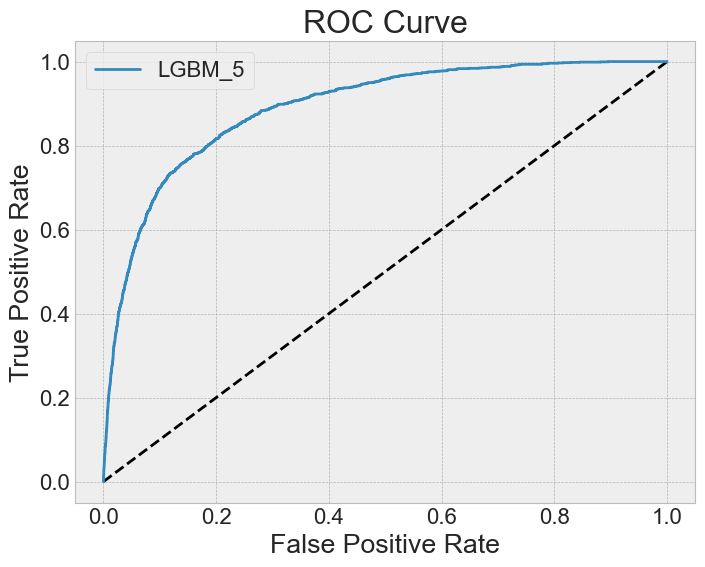

In [24]:
from joblib import dump

# the best parameters found so far
# best_params = {'bagging_fraction': 0.2492521343110019, 'feature_fraction': 0.37414076915242245, 'learning_rate': 0.013397117273577437, 'max_depth': 11.83761423222268, 'min_child_samples': 49.82361410549061, 'n_estimators': 723.8664305066139, 'num_leaves': 84.86435336500138}
# best_params = {'bagging_fraction': 0.14963398831428684, 'feature_fraction': 0.4005721464741433, 'learning_rate': 0.020510647658264772, 'max_depth': 14.304541193883065, 'min_child_samples': 39.92404870087559, 'n_estimators': 664.7925900297756, 'num_leaves': 24.62050040362543}
best_params = {'bagging_fraction': 0.2492521343110019, 'feature_fraction': 0.37414076915242245, 'learning_rate': 0.013397117273577437, 'max_depth': 11.83761423222268, 'min_child_samples': 49.82361410549061, 'n_estimators': 936.6663559297552, 'num_leaves': 84.86435336500138}

best_n_estimators = int(round(best_params['n_estimators']))
best_max_depth = int(round(best_params['max_depth']))
best_learning_rate = best_params['learning_rate']
best_num_leaves = int(round(best_params['num_leaves']))
best_min_child_samples = int(round(best_params['min_child_samples']))
best_feature_fraction = best_params['feature_fraction']
best_bagging_fraction = best_params['bagging_fraction']

lgbm = LGBMClassifier(n_estimators=best_n_estimators,
                    max_depth=best_max_depth,
                    learning_rate=best_learning_rate,
                    num_leaves=best_num_leaves,
                    min_child_samples=best_min_child_samples,
                    feature_fraction=best_feature_fraction,
                    bagging_fraction=best_bagging_fraction,
                    class_weight='balanced', random_state=SEED)
lgbm.fit(X_train, y_train) # , categorical_feature=cat_fs

# save model
dump(lgbm, 'lgbm_5.joblib')

# predict
y_pred = lgbm.predict(X_test)  
y_pred_proba = lgbm.predict_proba(X_test)[:,1]

roc_curve_list = []
roc_curve_list += [('LGBM_5', y_test, y_pred, y_pred_proba)]
metp.scores_and_matrix('LGBM_5', y_test, y_pred, y_pred_proba)
metp.all_roc_curves(roc_curve_list)

## **Test Data**

In [25]:
# load the data
client_test = pd.read_csv('data/client_test.csv')
invoice_test = pd.read_csv('data/invoice_test.csv')

# merge client and invoice data
df_test = pd.merge(client_test, invoice_test, on='client_id', how='left')
df_test.shape

df_test = data_processor(df_test)
#categories = extract_categories(df_test, cat_fs)
df_test = data_aggregator(df_test, cat_fs, categories)

# drop features, get the final dataframe
df_test.drop(columns=drop_fs+drop_lst, inplace=True, errors='ignore')
df_test.shape

(58069, 143)

In [26]:
test_without_id = df_test.drop('client_id', axis=1)

# load the model
# lgbm = load('models/lgbm_5.joblib')

# predict the probability
y_pred_proba = lgbm.predict_proba(test_without_id)[:,1]


In [27]:
submission = pd.DataFrame({'client_id': df_test['client_id'], 'target': y_pred_proba})
submission.to_csv('Submission/Submission_lgbm.csv', index=False)